# Final Project: Natural Language Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


sns.set_theme(style="whitegrid")

### Conversation Data

In [ ]:
df = pd.read_json(
    'data/chatbot-arena-conversations.jsonl.gz',
    lines=True,
)
df.shape

### Embedding Data

In [ ]:
embeddings = np.load(
    "data/chatbot-arena-prompts-embeddings.npy"
)
embeddings.shape

In [ ]:
embeddings_sample = embeddings[:1000]

# compute the dot product between the embeddings
dot_product = np.dot(embeddings_sample, embeddings_sample.T)
dot_product.shape

(1000, 1000)

### Topic Modeling and Hardness Score Data

In [ ]:
topic_and_hardness = pd.read_json(
    "data/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
)
topic_and_hardness.shape

## Data Inspection

### Null and NaN Values Inspection in Conversation Data

In [ ]:
# inspect Null and NaN values in the Conversation Data
print("Are there any null values in Conversation Data? ", df.isnull().values.any())
print("--------------------")
print("Inspect DataFrame:")
print("--------------------")
df.isna().sum()

Are there any null values in Conversation Data?  False
--------------------
Inspect DataFrame:
--------------------


question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
prompt            0
prompt_length     0
dtype: int64

In [ ]:
# inspect Null and NaN values in Topic Modeling and Hardness Score Data
print("Are there any null values in Topic Modeling and Hardness Score Data? ", topic_and_hardness.isnull().values.any())
print("--------------------")
print("Inspect DataFrame:")
print("--------------------")
topic_and_hardness.isna().sum()

Are there any null values in Topic Modeling and Hardness Score Data?  True
--------------------
Inspect DataFrame:
--------------------


question_id                          0
prompt                               0
openai_scores_raw_choices_nested     0
topic_modeling_1                    27
score_reason_1                      27
score_value_1                       27
topic_modeling_2                    27
score_reason_2                      27
score_value_2                       27
topic_modeling_3                    27
score_reason_3                      27
score_value_3                       27
dtype: int64

In [ ]:
display(df.shape)
display(topic_and_hardness.shape)

(25316, 9)

(25316, 12)

Based on the results, there are null values in `topic_and_hardness` DataFrame. Only 27 rows contain NaN values out of 25,322 rows, which is only 0.1% of the dataset. Since this is a very small portion of the data, we will be filtering out these rows as part of our data cleaning process.

### Duplicate Entries Inspection

Find duplicate rows based on `question_id`

In [ ]:
# Find duplicates based on question_id in Conversation Data
grouped_df = df.groupby('question_id').size().reset_index(name='counts')
duplicates_df = grouped_df[grouped_df['counts'] > 1]

print(f"Number of `question_id` with duplicates in Conversation Data: {len(duplicates_df)}")
print("----------------------------------------------------------------")
print(duplicates_df)

Number of `question_id` with duplicates in Conversation Data: 10
----------------------------------------------------------------
                            question_id  counts
59     00b5a7d8b1c04eda8a350b4a899b1f8e       2
1316   0dc56eb2858242099b329bd9674c439e       2
2926   1dd6137eb3c3470989e18ab729ccc0b3       2
3228   20cb94a0b7c147fe8fc6250b2a20fd1c       2
7224   49c49843372a4510926e9a572dbcb6f7       2
19276  c34923a07f514a1a902e96b9ef6400b3       2
19311  c3a1ad0511084ca68a264ad16fac8bdf       2
19553  c6192fdbd3dd46c98791d7abac92b56d       2
22733  e6635ff960d6431bbdebb9b78ffc2912       2
23381  ece135ff5264475d8fa3f9e1198b652f       2


In [ ]:
# Find duplicates based on question_id in Topic Modeling and Hardness Score Data
grouped_topic_and_hardness = topic_and_hardness.groupby('question_id').size().reset_index(name='counts')
duplicates_topic_and_hardness = grouped_topic_and_hardness[grouped_topic_and_hardness['counts'] > 1]

print(f"Number of `question_id` with duplicates in opic Modeling and Hardness Score Data: {len(duplicates_topic_and_hardness)}")
print("------------------------------------------------------------------------------------")
print(duplicates_topic_and_hardness)

Number of `question_id` with duplicates in opic Modeling and Hardness Score Data: 10
------------------------------------------------------------------------------------
                            question_id  counts
59     00b5a7d8b1c04eda8a350b4a899b1f8e       2
1316   0dc56eb2858242099b329bd9674c439e       2
2926   1dd6137eb3c3470989e18ab729ccc0b3       2
3228   20cb94a0b7c147fe8fc6250b2a20fd1c       2
7224   49c49843372a4510926e9a572dbcb6f7       2
19276  c34923a07f514a1a902e96b9ef6400b3       2
19311  c3a1ad0511084ca68a264ad16fac8bdf       2
19553  c6192fdbd3dd46c98791d7abac92b56d       2
22733  e6635ff960d6431bbdebb9b78ffc2912       2
23381  ece135ff5264475d8fa3f9e1198b652f       2


In [ ]:
# Check if the duplicates based on question_id are the same in both data
identical_question_id = (duplicates_topic_and_hardness['question_id'] == duplicates_df['question_id']).all()

print(f"Duplicate question_id are the same in both data: {identical_question_id}")

Duplicate question_id are the same in both data: True


Based on results, there are 10 `question_id` with duplicates. Duplicate entries will be removed as part of the data cleaning process.

### Prompt length distribution

In [ ]:
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)

0    What is the difference between OpenCL and CUDA?
Name: prompt, dtype: object

In [ ]:
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe()

count    25316.000000
mean       197.173922
std        369.892648
min         16.000000
25%         42.000000
50%         72.000000
75%        156.000000
max       2560.000000
Name: prompt_length, dtype: float64

Looks like the mean length of the prompt is about 200 characters, while the *median* is 72 characters. This suggests that the distribution is right-skewed! Let's visualize this.

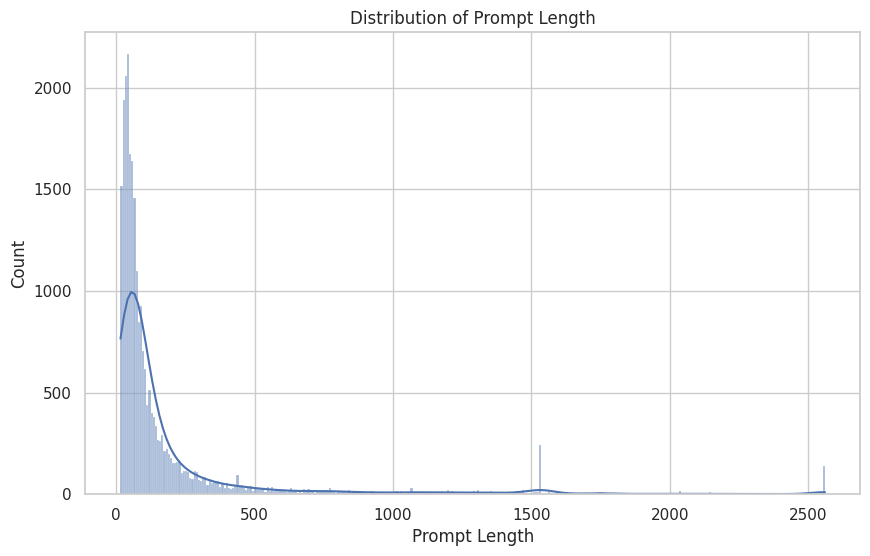

In [ ]:
# plot the distribution of the length of the prompt
plt.figure(figsize=(10, 6))
sns.histplot(df["prompt_length"], kde=True)
plt.xlabel("Prompt Length")
plt.title("Distribution of Prompt Length");

Looking at the length distribution of the prompt, we see that the mean length is about 200 characters, while the median is 72 characters. This suggests that there might be outliers in the data. Above we also provided a distribution plot which shows the data is right-skewed. For data cleaning purposes, we should focus on the correct range of lengths and remove the outliers from this dataset.

To identify outliers in the dataset, we can use the Interquartile Range (IQR) method. The IQR is the difference between the third quartile (75%) and the first quartile (25%). Values that fall below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR are considered outliers.

Given our data: First Quartile (25%) = 42 Third Quartile (75%) = 156 IQR = Third Quartile - First Quartile

By calculating the IQR and then determining the lower and upper bounds, we can identify the outliers. The calculations show that values below -129 or above 327 are considered outliers in this dataset. Given the nature of the data, the lower bound does not apply since we cannot have negative counts. Thus, any value above 327 is considered an outlier.

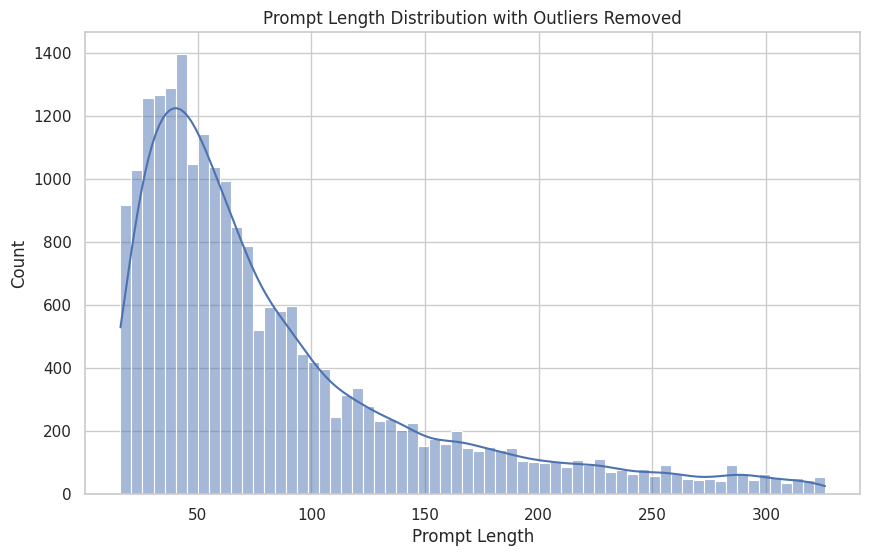

In [ ]:
# Plot the distribution without outliers
df = df[df["prompt_length"] < 327]
plt.figure(figsize=(10, 6))
sns.histplot(df["prompt_length"], kde=True)
plt.xlabel("Prompt Length")
plt.title("Prompt Length Distribution with Outliers Removed");

### Explore Vote Distribution

To analyze if there is any noticable bias towards one model over another through distribution of votes (winner column) visualization

In [ ]:
vote_distribution = df['winner'].value_counts()

vote_distribution

winner
model_a          7874
model_b          7739
tie (bothbad)    3968
tie              2502
Name: count, dtype: int64

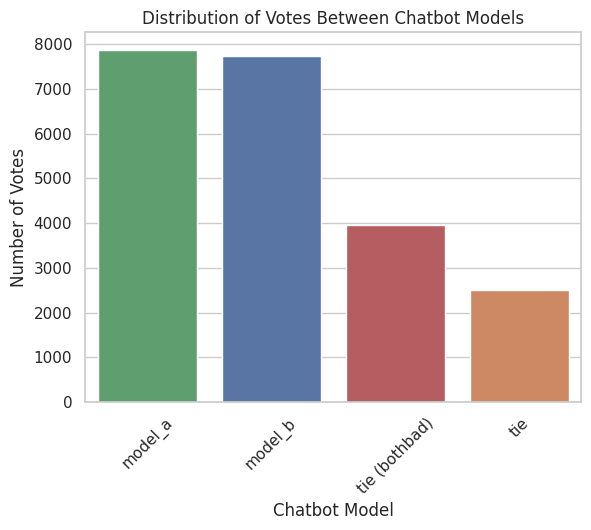

In [ ]:
# Plot the distribution of votes
sns.countplot(data=df, x='winner', order=vote_distribution.index, hue='winner')
plt.title("Distribution of Votes Between Chatbot Models")
plt.xlabel("Chatbot Model")
plt.ylabel("Number of Votes")
plt.xticks(rotation=45) # Rotate the x labels to make them readable
plt.show();

Observations:


*   Close competition between models: The votes for `model_a` (7874) and `model_b` (7739) are quite close, with `model_a` receiving slightly more votes. This suggests that both models performed similarly in terms of satisfying the users.

*   Significant number of ties: A considerable number of votes resulted in a tie, with 2502 instances where users found both answers quite equally good (tie) and 3968 instances where both answers are equally bad (`tie (bothbad)`)

*   No clear bias towards a specific model: the relatively balanced distribution of votes between `model_a` and `model_b`, with neither model dominating the other, suggests that there is no clear bias towards one model over the other among users.



In [ ]:
def standardize_topics_in_df(df, columns=['topic_modeling_1', 'topic_modeling_2', 'topic_modeling_3']):
    '''
    This function standardizes topics in specified columns by alphabetizing word pairs.
    Words are first split, then any hyphens are removed, and words are set to lowercase.
    Pairs are sorted alphabetically, ensuring consistency across the DataFrame.
    The function can handle comma-separated values by choosing the first valid pair found.

    Parameters
    ----------
    df : DataFrame
        The DataFrame containing the topic columns to be standardized.
    columns : list of str
        The column names to be standardized.

    Returns
    -------
    DataFrame
        The DataFrame with standardized topic columns.
    '''

    def standardize(topic):
        # Normalize by replacing hyphens with spaces and lowering the case
        normalized_topic = topic.replace('-', ' ').lower()

        # Split on commas, then further split on spaces, and sort
        all_segments = [segment.split() for segment in normalized_topic.split(',')]

        # Store only pairs of words
        word_pairs = [' '.join(sorted(segment)) for segment in all_segments if len(segment) == 2]

        # If there are no pairs, flatten the list of words and take the first two after sorting
        if not word_pairs:
            all_words = [word for segment in all_segments for word in segment]
            word_pairs = [' '.join(sorted(all_words[:2]))] if all_words else ['']

        # Return the first standardized pair or an empty string
        return word_pairs[0]

    for column in columns:
        df.loc[:, column] = df[column].astype(str).apply(standardize)

    return df

In [ ]:
# a function to standardize the score value to only keep the numbers
def extract_number_from_string(s):

    #regex to find all numbers in the string
    numbers = re.findall(r'\d+', s)
    # Return the first number found as an integer, or return None if no number is found
    return int(numbers[0]) if numbers else None

In [ ]:
def clean_df(df, outlier_threshold = 327):
    #1 Remove null values
    df_filtered = df.dropna()

    #2 drop duplicates
    df_filtered = df_filtered.drop_duplicates(subset='question_id')

    #3 Remove prompt length outliers
    df_filtered = df_filtered [df_filtered ["prompt_length"] < outlier_threshold]

    #4 standardize topic modelings
    df_filtered = standardize_topics_in_df(df_filtered)

    #5 extract number from score value column (e.g 6 from [[6]])
    df_filtered['score_value_1'] = df_filtered['score_value_1'].apply(lambda x: extract_number_from_string(str(x)))
    df_filtered['score_value_2'] = df_filtered['score_value_2'].apply(lambda x: extract_number_from_string(str(x)))
    df_filtered['score_value_3'] = df_filtered['score_value_3'].apply(lambda x: extract_number_from_string(str(x)))

    #6 Now convert these columns to numeric
    df_filtered['score_value_1'] = pd.to_numeric(df_filtered['score_value_1'], errors='coerce')
    df_filtered['score_value_2'] = pd.to_numeric(df_filtered['score_value_2'], errors='coerce')
    df_filtered['score_value_3'] = pd.to_numeric(df_filtered['score_value_3'], errors='coerce')

    return df_filtered

### Data Processing

In [ ]:
# Merge the DataFrames
merged_df = pd.merge(df, topic_and_hardness[['question_id', "topic_modeling_1","score_reason_1","score_value_1",\
                        "topic_modeling_2","score_reason_2","score_value_2",\
                         "topic_modeling_3","score_reason_3","score_value_3"]], left_index=True, right_index=True,)
#merged_df.head(1)

In [ ]:
# Here I check if every element in 'question_id_x' is equal to 'question_id_y'
columns_are_identical = (merged_df['question_id_x'] == merged_df['question_id_y']).all()

print(f"All question_id columns are the same: {columns_are_identical}")

All question_id columns are the same: True


In [ ]:
# now we can drop one of the question_id columns to save memory
merged_df=merged_df.drop(columns=['question_id_y'])

# Rename 'question_id_x' to 'question_id'
merged_df=merged_df.rename(columns={'question_id_x': 'question_id'})

#if you run this cell twice it an error will pop-up since the columns are already removed.

In [ ]:
# add average score column
merged_df['score_value_1'] = pd.to_numeric(merged_df['score_value_1'], errors='coerce')
merged_df['score_value_2'] = pd.to_numeric(merged_df['score_value_2'], errors='coerce')
merged_df['score_value_3'] = pd.to_numeric(merged_df['score_value_3'], errors='coerce')

merged_df['average_score'] = merged_df[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)

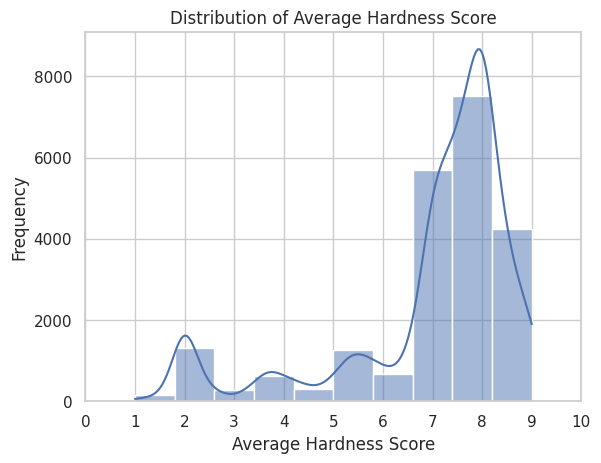

In [ ]:
# Plot average hardness score distribution
sns.histplot(data=merged_df['average_score'], bins=10, kde=True)
plt.title('Distribution of Average Hardness Score')
plt.xlabel('Average Hardness Score')
plt.ylabel('Frequency')
plt.xticks(range(0, 11))
plt.show();

In [ ]:
merged_df = clean_df(merged_df)
print(merged_df.shape)
print(merged_df.columns)

(21306, 19)
Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'prompt_length',
       'topic_modeling_1', 'score_reason_1', 'score_value_1',
       'topic_modeling_2', 'score_reason_2', 'score_value_2',
       'topic_modeling_3', 'score_reason_3', 'score_value_3', 'average_score'],
      dtype='object')


The merged_df is our cleaned merged dataframe. It does not contain embedding information.

### Embedding data processing

In [ ]:
#convert embedding_df to dataframe

embeddings_df = pd.DataFrame(embeddings)
#embeddings_df.head(1)

In [ ]:
#only keep indexes that are present in the merged_df
common_indexes = embeddings_df.index.intersection(merged_df.index)
embeddings_df_cleaned = embeddings_df.loc[common_indexes]
embeddings_df_cleaned.shape

(21306, 256)

In [ ]:
# now that embedding is filtered we can convert it back to array
cleaned_embeddings = embeddings_df_cleaned.values






*   `embeddings` (array) : Original embedding data.
*   `embeddings_df` (DataFrame) : Orignal embedding converted to a DataFrame.
*   `embeddings_df_cleaned` (DataFrame) : Cleaned embedding DataFrame with indexes that are present in the `merged_df` DataFrame.
*   `cleaned_embeddings` (array) : Cleaned embedding array with only indexes that are present in the merged_df



# Winner model prediction

In [ ]:
#pairwise win fraction
def compute_pairwise_win_fraction(merged_df, max_num_models=30):
    # Times each model wins as Model a
    a_win_ptbl = pd.pivot_table(
        merged_df[merged_df['winner'] == "model_a"],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Table counting times each model wins as Model b
    b_win_ptbl = pd.pivot_table(
        merged_df[merged_df['winner'] == "model_b"],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Table counting number of a-b pairs
    num_battles_ptbl = pd.pivot_table(merged_df,
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Computing the proportion of wins for each model as a and as b
    # against all other models
    row_beats_col_freq = (
        (a_win_ptbl + b_win_ptbl.T) /
        (num_battles_ptbl + num_battles_ptbl.T)
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    prop_wins = prop_wins[:max_num_models]
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col

In [ ]:
def visualize_pairwise_win_fraction(merged_df, title, max_num_models=30):
    # Compute the pairwise win fraction matrix
    row_beats_col = compute_pairwise_win_fraction(merged_df, max_num_models)

    # Create the heatmap using Seaborn
    plt.figure(figsize=(12, 10))  # Adjust the size as needed
    ax = sns.heatmap(row_beats_col, annot=True, fmt=".2f", cmap='RdBu', linewidths=.5,
                     cbar_kws={'label': 'Fraction of Wins'})
    ax.set_title(title)
    ax.set_xlabel("Model B: Loser")
    ax.set_ylabel("Model A: Winner")
    plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if needed
    plt.yticks(rotation=0)
    plt.show()

In [ ]:
Winner_no_ties = merged_df[~merged_df["winner"].str.contains("tie")]
win_fraction = compute_pairwise_win_fraction(Winner_no_ties, max_num_models=30)

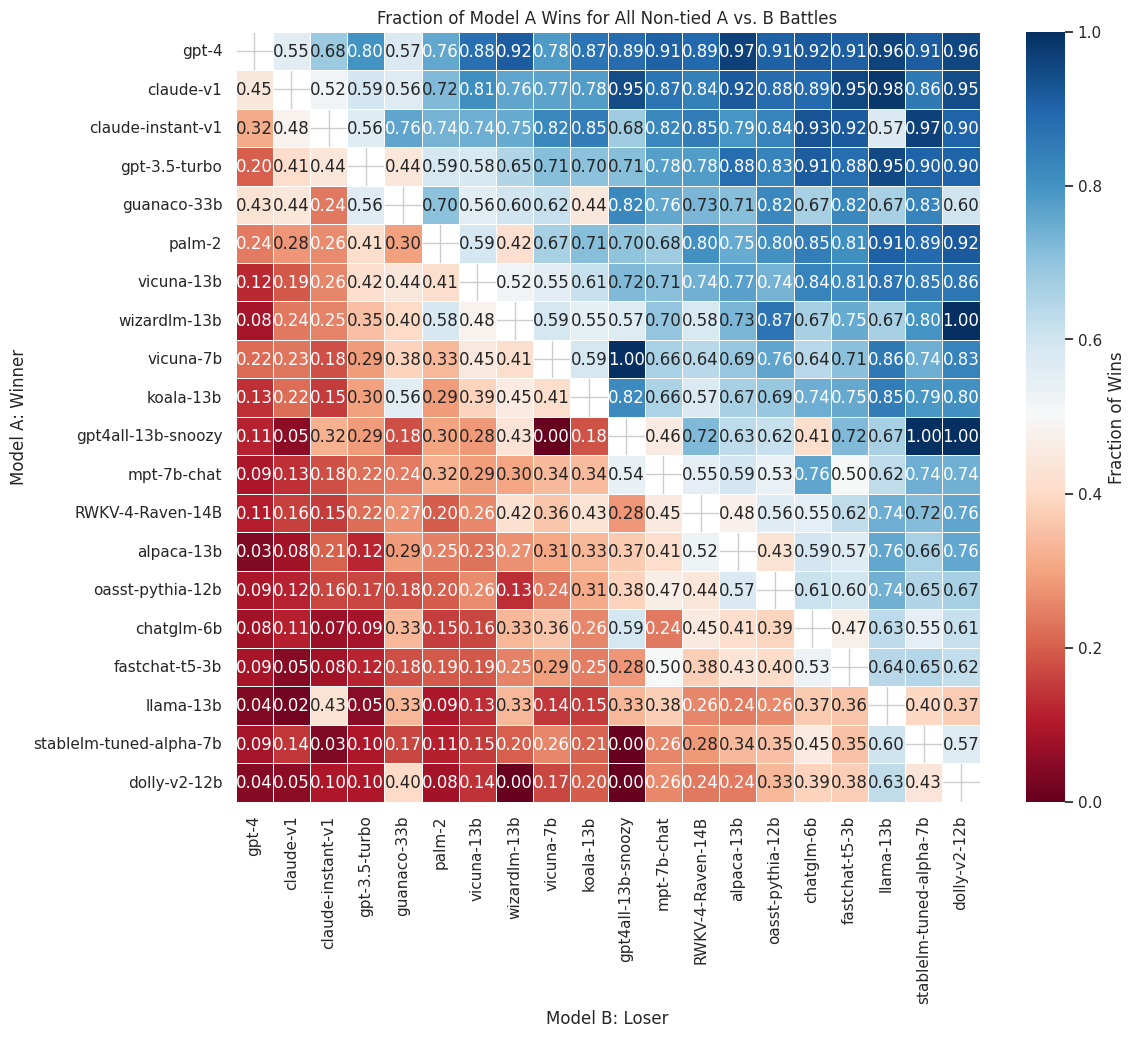

In [ ]:
fig_1 = visualize_pairwise_win_fraction(Winner_no_ties,
     title = "Fraction of Model A Wins for All Non-tied A vs. B Battles")

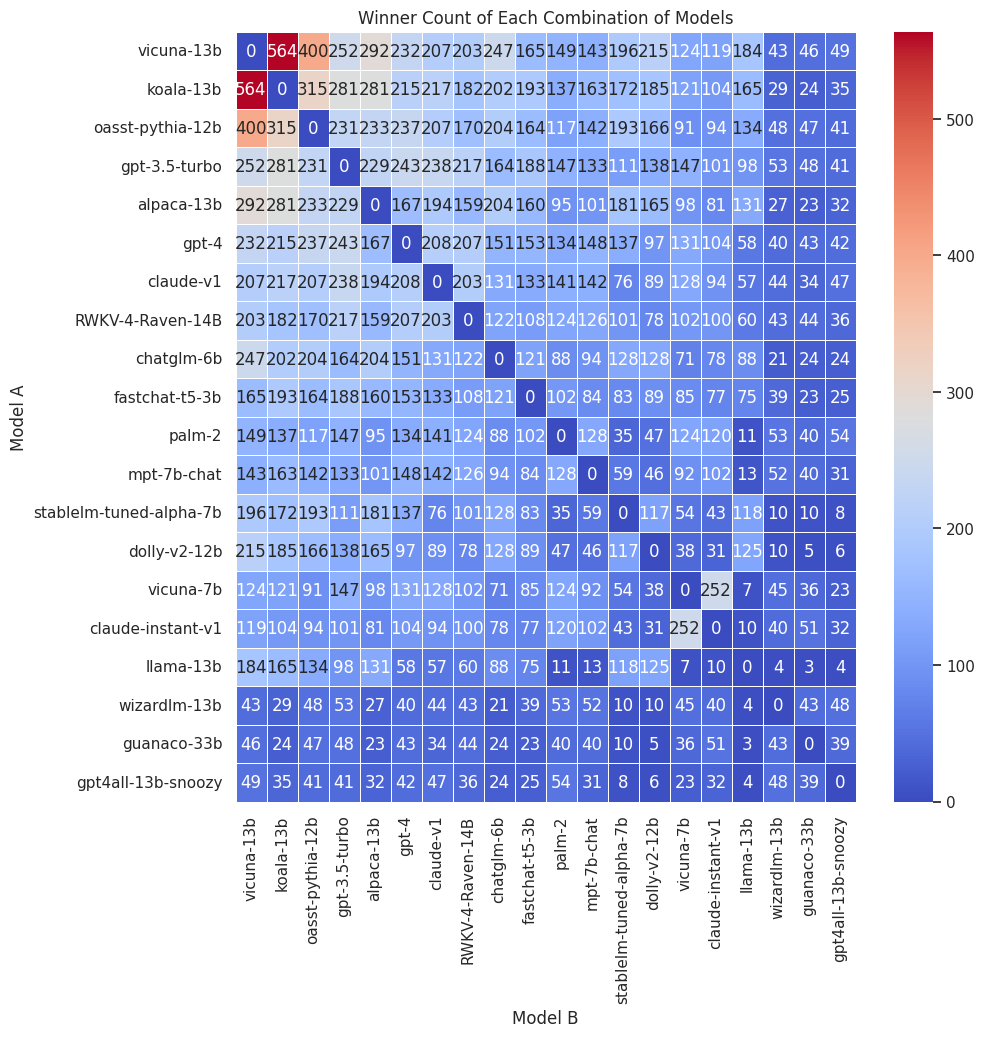

In [ ]:
#creates heat map for winner count of each combination models
def visualize_battle_count(merged_df, title, show_num_models=30):
    ptbl = pd.pivot_table(merged_df, index="model_a", columns="model_b", aggfunc="size",
                          fill_value=0)
    battle_counts = ptbl + ptbl.T

    ordering = battle_counts.sum().sort_values(ascending=False).index[:show_num_models]

    # Subset the matrix to only the top models for clearer visualization
    battle_matrix = battle_counts.loc[ordering, ordering]

    # Create the heatmap using Seaborn
    plt.figure(figsize=(10, 10))  # Set the figure size larger to accommodate labels
    sns.heatmap(battle_matrix, annot=True, fmt="d", cmap='coolwarm', linewidths=.5)
    plt.title(title)
    plt.xlabel("Model B")
    plt.ylabel("Model A")
    plt.show()

fig = visualize_battle_count(merged_df, title="Winner Count of Each Combination of Models", show_num_models=30)

In [ ]:
# Adding the 'model-a win fraction' column by looking up the correct entry in win_fraction
merged_df['model-a win fraction'] = merged_df.apply(
    lambda row: win_fraction.at[row['model_a'], row['model_b']], axis=1
)

In [ ]:
#computing ELO rating here
#ELO Rating
from collections import defaultdict

def compute_online_elo(merged_df, K=4, SCALE=400, BASE=10, INIT_RATING=1000):
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, winner in merged_df[['model_a', 'model_b', 'winner']].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE))
        if winner == "model_a":
            sa = 1
        elif winner == "model_b":
            sa = 0
        elif winner == "tie" or winner == "tie (bothbad)":
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {winner}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)

    # calibrate llama-13b to 800
    delta = (800-rating["llama-13b"])
    for model in merged_df["model_a"].unique():
        rating[model] += delta

    return rating

def preety_print_model_ratings(ratings):
    df = pd.DataFrame([
        [n, ratings[n]] for n in ratings.keys()
    ], columns=["Model", "Elo rating"]).sort_values("Elo rating", ascending=False).reset_index(drop=True)
    # df["Elo rating"] = (df["Elo rating"] + 0.5).astype(int)
    df.index = df.index + 1
    return df

In [ ]:
online_elo_ratings = compute_online_elo(merged_df)
preety_print_model_ratings(online_elo_ratings)

,Model,Elo rating
1,gpt-4,1146.470637
2,claude-v1,1128.968883
3,claude-instant-v1,1100.264798
4,gpt-3.5-turbo,1046.514677
5,guanaco-33b,1037.662585
6,palm-2,1008.338058
7,vicuna-13b,985.755986
8,vicuna-7b,985.656296
9,wizardlm-13b,980.489436
10,koala-13b,968.981895


In [ ]:
# Convert defaultdict to DataFrame
elo_df = pd.DataFrame(list(online_elo_ratings.items()), columns=['Model', 'ELO rating'])

# Check if 'rank_model_a' already exists; if not, perform the merge to avoid error for 2nd run
if 'rank_model_a' not in merged_df.columns:
    merged_df = merged_df.merge(elo_df, left_on='model_a', right_on='Model', how='left')
    merged_df.rename(columns={'ELO rating': 'rank_model_a'}, inplace=True)
    merged_df.drop(columns='Model', inplace=True)  # Drop the extra 'Model' column after merge

if 'rank_model_b' not in merged_df.columns:
    merged_df = merged_df.merge(elo_df, left_on='model_b', right_on='Model', how='left')
    merged_df.rename(columns={'ELO rating': 'rank_model_b'}, inplace=True)
    merged_df.drop(columns='Model', inplace=True)

In [ ]:
# Calculate the ranking ratio
merged_df['ranking_ratio'] = merged_df['rank_model_a'] / merged_df['rank_model_b']

In [ ]:
copy_merged_df = merged_df.reset_index()

#filtering to exclude tie cases
no_tie = copy_merged_df[(copy_merged_df['winner']=='model_a') | (copy_merged_df['winner']=='model_b')]
no_tie.reset_index(drop=True, inplace=True)
no_tie_embeddings = cleaned_embeddings[no_tie.index]

def apply_kmeans_to_embeddings_and_onehot(df, embeddings, n_clusters=51):
    # Clustering on embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    clusters = kmeans.fit_predict(embeddings)

    # Adding cluster IDs to the DataFrame
    df = df.copy()
    df['cluster_id'] = clusters

    # One-hot Encoding
    onehot_encoder = OneHotEncoder(sparse_output=False)
    onehot_encoded = onehot_encoder.fit_transform(df[['cluster_id']])

    # Creating DataFrame for one-hot encoded features
    cluster_columns = [f'cluster_{i}' for i in range(n_clusters)]
    onehot_df = pd.DataFrame(onehot_encoded, columns=cluster_columns, index=df.index)

    # Merging the one-hot encoded DataFrame with the original DataFrame
    df = pd.concat([df, onehot_df], axis=1)

    return df

no_tie = apply_kmeans_to_embeddings_and_onehot(no_tie, no_tie_embeddings, n_clusters=51)

In in this task, we explored multiple approaches to predict the outcome between "model-a", "model-b", or a "tie" scenario. Initially, we experimented with various modeling techniques, including multi-class logistic regression and ensembles, while also considering the incorporation of clustering, including prompt embedding. However, despite these efforts, we encountered challenges in effectively distinguishing "tie" cases from "model-a" and "model-b" outcomes.
Upon closer examination, we observed that the probabilities ratio for "model-a" and "model-b" in "tie" cases did not exhibit a significant difference compared to non-tie scenarios. This discrepancy indicated potential limitations within our model's predictive capabilities. Consequently, we decided to focus solely on "model-a" and "model-b" outcomes, disregarding "tie" cases in our modeling process.
By narrowing the scope to exclude tie scenarios, we were able to refine the model and achieve the desired threshold for the validation data. This strategic adjustment allowed us to overcome the challenges posed by tie cases, ultimately leading to improved performance and accuracy in predicting the winner between "model-a" and "model-b".

In [ ]:
#only model to predict model_a and model_b (binary model)

label_encoder = LabelEncoder()
no_tie['winner_encoded'] = label_encoder.fit_transform(no_tie['winner'])

cluster_columns = [f'cluster_{i}' for i in range(0, 51)]
#Features_cols = ["prompt_length",'ranking_ratio', 'model-a win fraction', cluster_columns]
Features_cols = ["prompt_length",'ranking_ratio', 'model-a win fraction']

Features_cols.extend(cluster_columns)
X = no_tie[Features_cols]
Y = no_tie['winner_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=300) # Increased max_iter to 300 to avoid Convergence warning
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7458526874585268


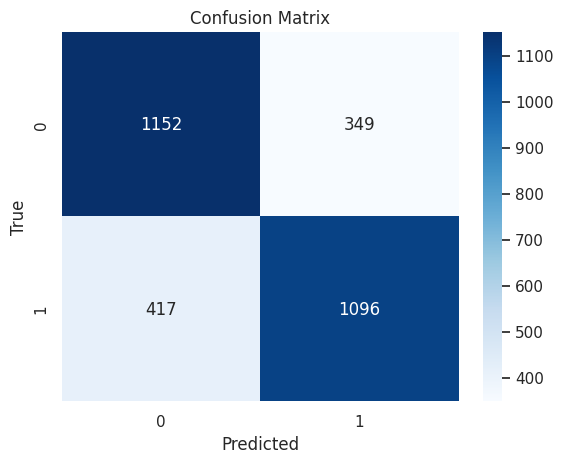

In [ ]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## KFold Cross Validation For Winner Model Prediction

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    # Split data into training and test for the current fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = Y.iloc[train_index], Y.iloc[test_index]

    train_embeddings_fold = cleaned_embeddings[train_index]

    kmeans = KMeans(n_clusters=51, n_init=20, random_state=42)
    train_clusters_fold = kmeans.fit_predict(train_embeddings_fold)

    cluster_models_fold = {}

    for cluster_id in np.unique(train_clusters_fold):
        cluster_indices = train_clusters_fold == cluster_id
        X_cluster = X_train_fold.values[cluster_indices]
        y_cluster = y_train_fold.values[cluster_indices]

        # Train model for the current cluster
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_cluster, y_cluster)

        cluster_models_fold[cluster_id] = model

    test_embeddings_fold = cleaned_embeddings[test_index]
    test_clusters_fold = kmeans.predict(test_embeddings_fold)

    fold_predictions = []
    fold_true_values = []

    for cluster_id in np.unique(test_clusters_fold):
        cluster_indices = test_clusters_fold == cluster_id
        X_test_cluster = X_test_fold.values[cluster_indices]
        y_test_cluster = y_test_fold.values[cluster_indices]

        if cluster_id in cluster_models_fold:
            model = cluster_models_fold[cluster_id]
            y_pred = model.predict(X_test_cluster)
            fold_predictions.extend(y_pred)
            fold_true_values.extend(y_test_cluster)

    fold_accuracy = accuracy_score(fold_true_values, fold_predictions)
    fold_accuracies.append(fold_accuracy)

    print(f"Fold {fold+1} Accuracy: {fold_accuracy}")

mean_accuracy = np.mean(fold_accuracies)
print(f"Mean accuracy across all folds: {mean_accuracy}")


Fold 1 Accuracy: 0.7365627073656271
Fold 2 Accuracy: 0.7415394824153948
Fold 3 Accuracy: 0.7408759124087592
Fold 4 Accuracy: 0.7471798274717982
Fold 5 Accuracy: 0.7421174908728841
Mean accuracy across all folds: 0.7416550841068926


**Calculating Overall Accuracy Including 'Tie' Cases**

The mean accuracy of **0.74** is calculated when we exclude 'tie' cases. However, the accuracy will be lower when we consider 'tie' cases. Below is how we can calculate it:

1. **Calculate the number of correct predictions in the `no_tie` dataframe**:
   - `len(no_tie) = 15069`
   - `len(merged_df) = 21306`
   - **Correct Predictions** = Total Data Points × Accuracy
   - **Correct Predictions** = `15069 × 0.74`

2. **Calculate the new accuracy**:
   - **Accuracy** = (Correct Predictions / Total Data Points)
   - **Accuracy** = `15069 × 0.74 / 21306` = **52.34%**

Thus, the overall accuracy on all the data points, considering 'tie' cases, is **52.34%**.


# Hardness Score Prediction

Linear Regression model will be used for hardness score prediction as it predicts a continuous outcome. The final predicted score output will be rounded using `np.round`.

### Baseline Performace

To train and test the model using the available data, `train_test_split` is used to split up training data and testing data. Keeping 80% of the dataset as the training data and 20% as unseen test data. The `random_state` is set to be 42 for reproducibility.

In [ ]:
# Baseline/initial perfomance of modeling with just embeddings
X_score = cleaned_embeddings
Y_score = merged_df['average_score'].values

# split embeddings & features into training and test sets
X_train_score, X_test_score, Y_train_score, Y_test_score = train_test_split(X_score, Y_score, test_size=0.2, random_state=42)

# Train linear regression model for hardness score prediction
score_model = LinearRegression().fit(X_train_score,  Y_train_score)

# predictions on both train and test sets
Y_train_score_predict = np.round(score_model.predict(X_train_score)).astype(int)
Y_test_score_predict = np.round(score_model.predict(X_test_score)).astype(int)

# calculates the MSE of training set and test set
score_train_error = mean_squared_error(Y_train_score, Y_train_score_predict)
score_test_error = mean_squared_error(Y_test_score, Y_test_score_predict)

print("Training MSE (baseline performance):", score_train_error)
print("Test MSE (baseline performance):", score_test_error)

Training MSE (baseline performance): 2.1383934392031083
Test MSE (baseline performance): 2.263419625632202


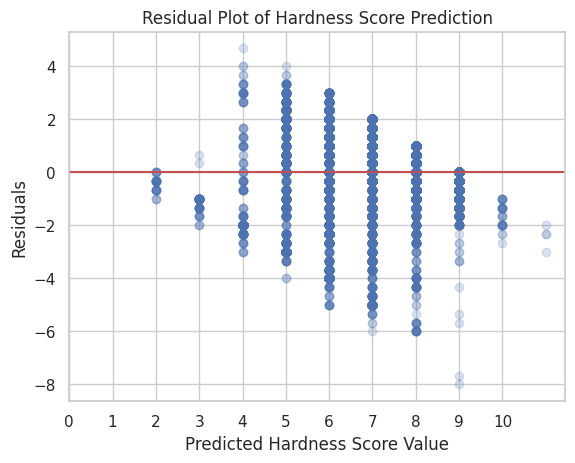

In [ ]:
# Residuals plot visualization
residuals = Y_train_score - Y_train_score_predict
plt.scatter(Y_train_score_predict, residuals, alpha=0.2)
plt.axhline(y=0, color='r')
plt.xlabel('Predicted Hardness Score Value')
plt.ylabel('Residuals')
plt.title('Residual Plot of Hardness Score Prediction')
plt.xticks(np.arange(0, 11, step=1))
plt.show();

From the baseline performance, testing data is showing a slightly higher MSE. This indicates that there is a slight overfit in the model.

### PCA Implementation

To see if dimensionality reduction would help to improve the model from being slightly overfitted.

Note: PCA did not improve error, but it is kept in notebook to show investigative process.

Total explained variance ratio of original dataset: 1.0000
--------------------------------------------------------------------------------------------


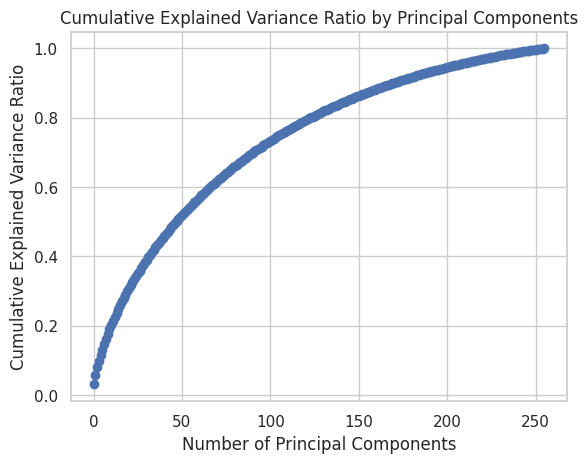

In [ ]:
# to reduce dimensionality of embedding features using PCA
pca = PCA()
X_score_pca = pca.fit_transform(X_score)

# to see if the explained variance ratio of original dataset adds up to 1
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()

# print(f"Explained variance ratio of original dataset: \n{explained_variance_ratio}")
print(f"Total explained variance ratio of original dataset: {total_explained_variance_ratio:.4f}")
print("--------------------------------------------------------------------------------------------")

# plot explained variance ratio to find n_components for modeling
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components');

In [ ]:
# to determine the optimal number of features to keep (at least 95% explained variance ratio)
n_components = 0
total_ratio = 0

for ratio in explained_variance_ratio:
  total_ratio += ratio
  if total_ratio < 0.95:
    n_components += 1
  else:
    break

print(f"The optimal number of components to keep (0.95 explained variance ratio): {n_components}")

The optimal number of components to keep (0.95 explained variance ratio): 204


In [ ]:
# assign X_score to use the optimal number of components
X_score = cleaned_embeddings[:, :n_components]
X_score.shape

(21306, 204)

In [ ]:
# split embeddings & features into training and test sets
X_train_score, X_test_score, Y_train_score, Y_test_score = train_test_split(X_score, Y_score, test_size=0.2, random_state=42)

# Train linear regression model for hardness score prediction
score_model = LinearRegression().fit(X_train_score,  Y_train_score)

# predictions on both train and test sets
Y_train_score_predict = np.round(score_model.predict(X_train_score)).astype(int)
Y_test_score_predict = np.round(score_model.predict(X_test_score)).astype(int)

# calculates the MSE of training set and test set
score_train_error = mean_squared_error(Y_train_score, Y_train_score_predict)
score_test_error = mean_squared_error(Y_test_score, Y_test_score_predict)

print("Training MSE (with PCA implementation):", score_train_error)
print("Test MSE (with PCA implementation):", score_test_error)

Training MSE (with PCA implementation): 2.2494589167905295
Test MSE (with PCA implementation): 2.2900894207205797


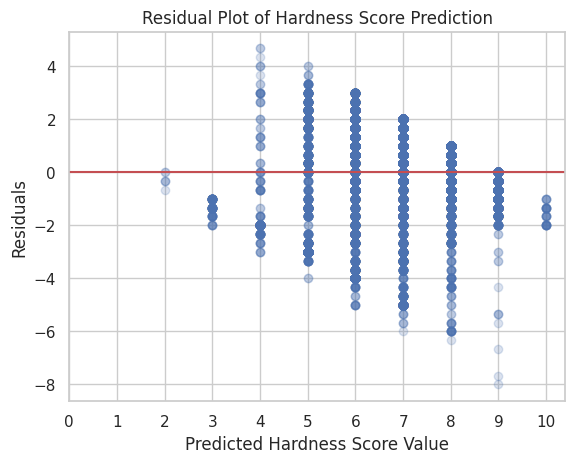

In [ ]:
# Residuals plot visualization
residuals = Y_train_score - Y_train_score_predict
plt.scatter(Y_train_score_predict, residuals, alpha=0.2)
plt.axhline(y=0, color='r')
plt.xlabel('Predicted Hardness Score Value')
plt.ylabel('Residuals')
plt.title('Residual Plot of Hardness Score Prediction')
plt.xticks(np.arange(0, 11, step=1))
plt.show()

To keep at least 0.95 explained variance ratio, we must keep 204 components in embeddings data. Reducing the dimensionality of the embeddings from 256 to 204 is a small reduction. This did not help in lowering the MSE and it followed the previous trend where the test MSE is slightly higher than the training MSE, indicating the model is still slightly overfitted.

### Top 10 topics vs. score value visualization

To visualize the relationship between the topics and the hardness scores and to understand the characteristics and performance of different topics based on the score values.

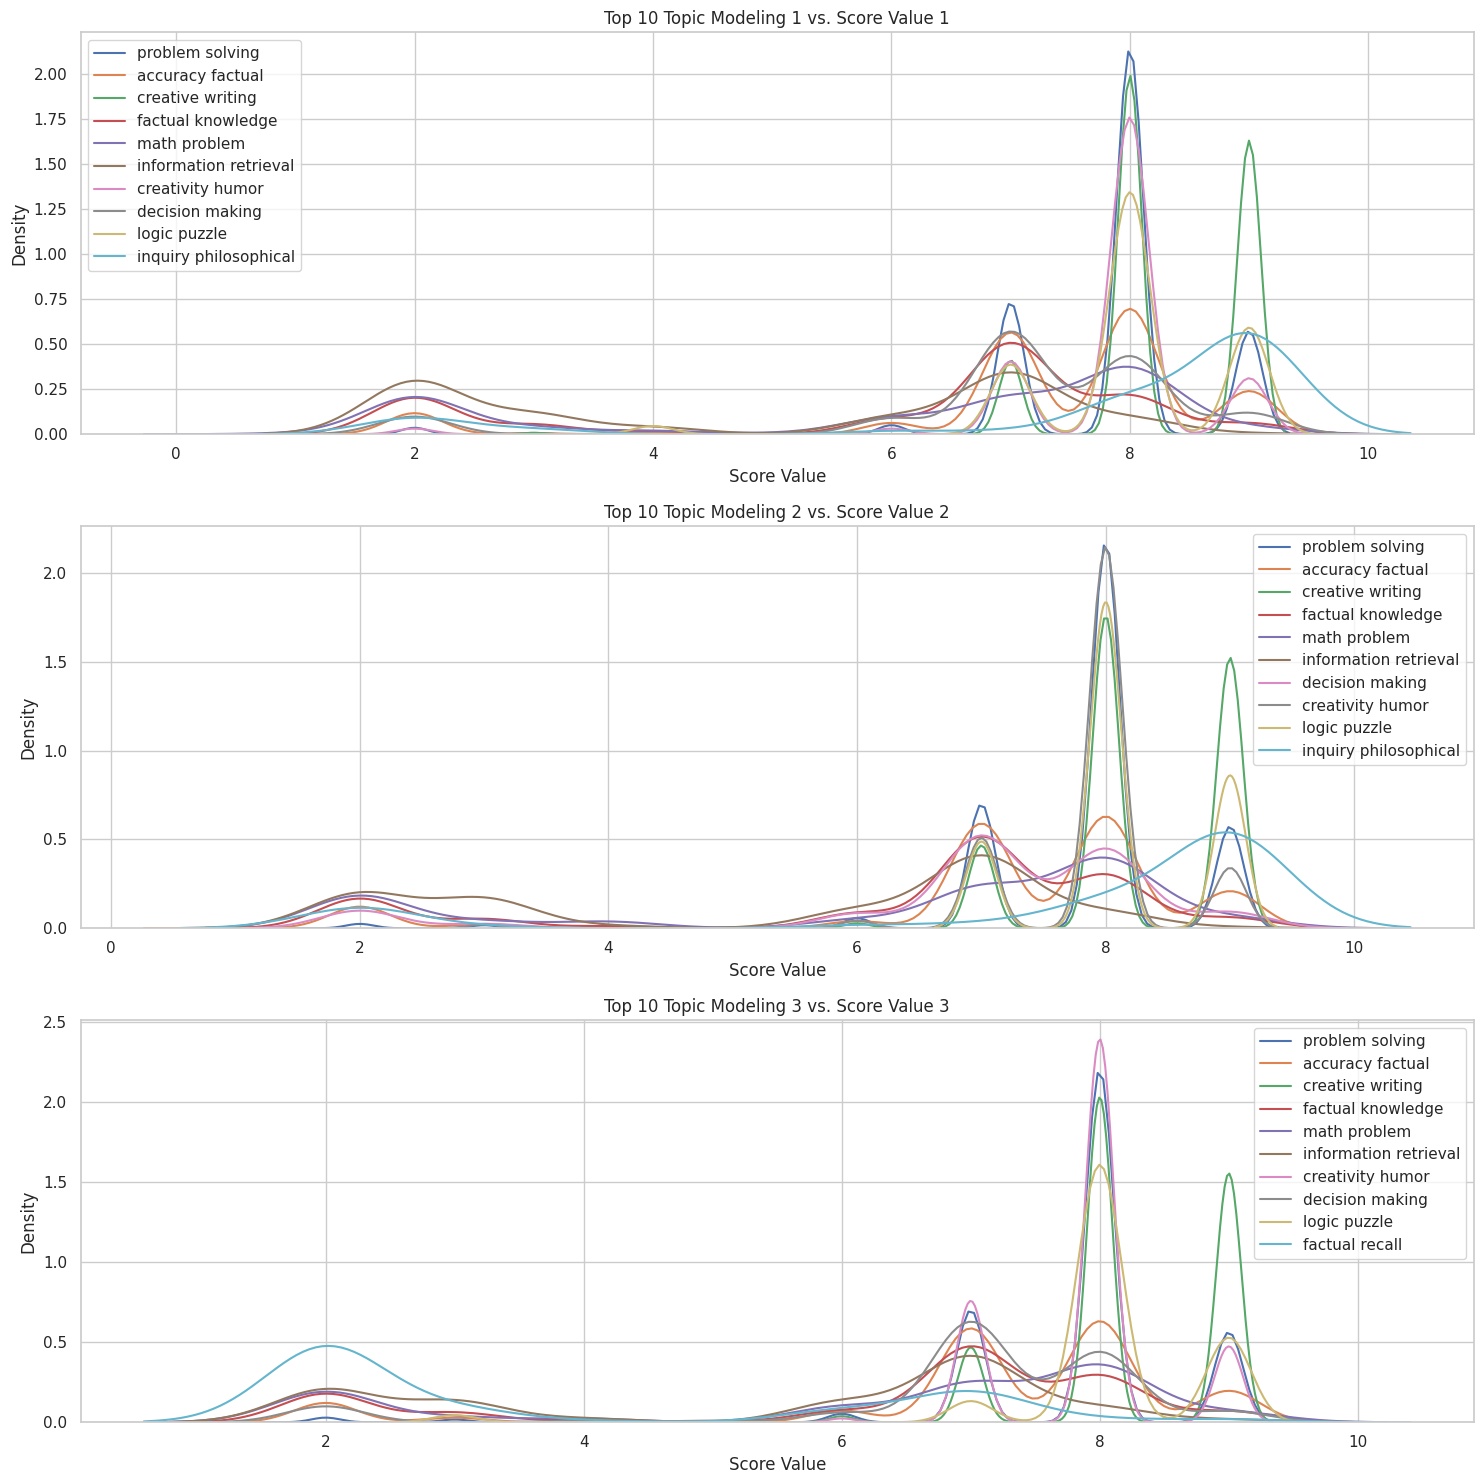

In [ ]:
# calculate the top 10 topic modeling
top10_topic_modeling_1 = merged_df['topic_modeling_1'].value_counts().nlargest(10).index.tolist()
top10_topic_modeling_2 = merged_df['topic_modeling_2'].value_counts().nlargest(10).index.tolist()
top10_topic_modeling_3 = merged_df['topic_modeling_3'].value_counts().nlargest(10).index.tolist()

# filter DataFrame to include only rows with the top 10 topic modeling
filtered_topic_modeling_1_df = merged_df[merged_df['topic_modeling_1'].isin(top10_topic_modeling_1)]
filtered_topic_modeling_2_df = merged_df[merged_df['topic_modeling_2'].isin(top10_topic_modeling_2)]
filtered_topic_modeling_3_df = merged_df[merged_df['topic_modeling_3'].isin(top10_topic_modeling_3)]

# plot for each topic modeling value vs. score value
plt.figure(figsize=(15, 15))

for i, (top_topic_modeling, filtered_df) in enumerate(zip([top10_topic_modeling_1, top10_topic_modeling_2, top10_topic_modeling_3],
 [filtered_topic_modeling_1_df, filtered_topic_modeling_2_df, filtered_topic_modeling_3_df]), 1):
    plt.subplot(3, 1, i)
    for topic in top_topic_modeling:
        sns.kdeplot(filtered_df[filtered_df[f'topic_modeling_{i}'] == topic][f'score_value_{i}'], label=topic, bw_adjust=0.5)
    plt.title(f"Top 10 Topic Modeling {i} vs. Score Value {i}")
    plt.xlabel('Score Value')
    plt.legend()

plt.tight_layout()
plt.show();

### OHE for topic modeling

Since topic_modeling columns are non-numeric features, topics needs to be tranformed to numeric features in order to be included as part of the data to be fitted in the hardness score prediction regression model.

In [ ]:
# perform OneHotEncode for topic modelings

def encoded_top_topic(df, top_n, topic_cols=['topic_modeling_1', 'topic_modeling_2', 'topic_modeling_3']):
  '''
  This function encodes the top n topics for the topic columns in a DataFrame using OneHotEncoder.

  Parameters
  ----------
  df : DataFrame
      The DataFrame containing the topic columns to be one-hot encoded.
  columns : list of str
      The column names to be one-hot encoded.
  top_n : int
      The number of top topics to encode.

  Returns
  -------
  DataFrame
      The DataFrame with one-hot encoded topic columns.
  '''
  # Empty list to store encoded DataFrames
  encoded_dfs = []

  # Encode each topic column
  for topic_col in topic_cols:
      # To get the top n topics for all topic columns
      top_topics = df[topic_col].value_counts().nlargest(top_n).index.values

      # Initialize a OneHotEncoder object for topic modeling
      ohe_topics = OneHotEncoder(handle_unknown='ignore')

      # Fit the encoder
      ohe_topics.fit(top_topics.reshape(-1, 1))

      # Use the encoder to transform
      encoded_topic = ohe_topics.transform(df[topic_col].values.reshape(-1, 1)).toarray()

      # Create DataFrame with encoded top n topics
      encoded_df = pd.DataFrame(encoded_topic, columns=[f"{topic_col}_{col}" for col in ohe_topics.get_feature_names_out()])

      # Append encoded DataFrame to the list
      encoded_dfs.append(encoded_df)

  # Concatenate encoded DataFrames
  encoded_topic_df = pd.concat(encoded_dfs, axis=1)

  return encoded_topic_df

top10_topics_encoded_df = encoded_top_topic(df=merged_df, top_n=10)
display(top10_topics_encoded_df.head(1))
print(top10_topics_encoded_df.shape)

,topic_modeling_1_x0_accuracy factual,topic_modeling_1_x0_creative writing,topic_modeling_1_x0_creativity humor,topic_modeling_1_x0_decision making,topic_modeling_1_x0_factual knowledge,topic_modeling_1_x0_information retrieval,topic_modeling_1_x0_inquiry philosophical,topic_modeling_1_x0_logic puzzle,topic_modeling_1_x0_math problem,topic_modeling_1_x0_problem solving,...,topic_modeling_3_x0_accuracy factual,topic_modeling_3_x0_creative writing,topic_modeling_3_x0_creativity humor,topic_modeling_3_x0_decision making,topic_modeling_3_x0_factual knowledge,topic_modeling_3_x0_factual recall,topic_modeling_3_x0_information retrieval,topic_modeling_3_x0_logic puzzle,topic_modeling_3_x0_math problem,topic_modeling_3_x0_problem solving
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(21306, 30)


In [ ]:
# To find the optimal number of top topics to OHE with low MSE
n = 50

training_mses = []
test_mses = []
num_topics = []

for i in range(n):
  # initialize/reset X (features) and Y
  X_score = cleaned_embeddings
  Y_score = merged_df['average_score'].values

  # OHE top topics
  top_topics_encoded_df = encoded_top_topic(df=merged_df, top_n=i+1)

  # concatenate encoded top topics as additional features
  X_score = np.concatenate((X_score, top_topics_encoded_df.values), axis=1)

  # split embeddings & features into training and test sets
  X_train_score, X_test_score, Y_train_score, Y_test_score = train_test_split(X_score, Y_score, test_size=0.2, random_state=42)

  # Train linear regression model for hardness score prediction
  score_model = LinearRegression().fit(X_train_score,  Y_train_score)

  # predictions on both train and test sets
  Y_train_score_predict = np.round(score_model.predict(X_train_score)).astype(int)
  Y_test_score_predict = np.round(score_model.predict(X_test_score)).astype(int)

  # calculates the MSE of training set and test set
  score_train_error = mean_squared_error(Y_train_score, Y_train_score_predict)
  score_test_error = mean_squared_error(Y_test_score, Y_test_score_predict)

  # append calculated MSEs and number of topics
  training_mses.append(score_train_error)
  test_mses.append(score_test_error)
  num_topics.append(i+1)

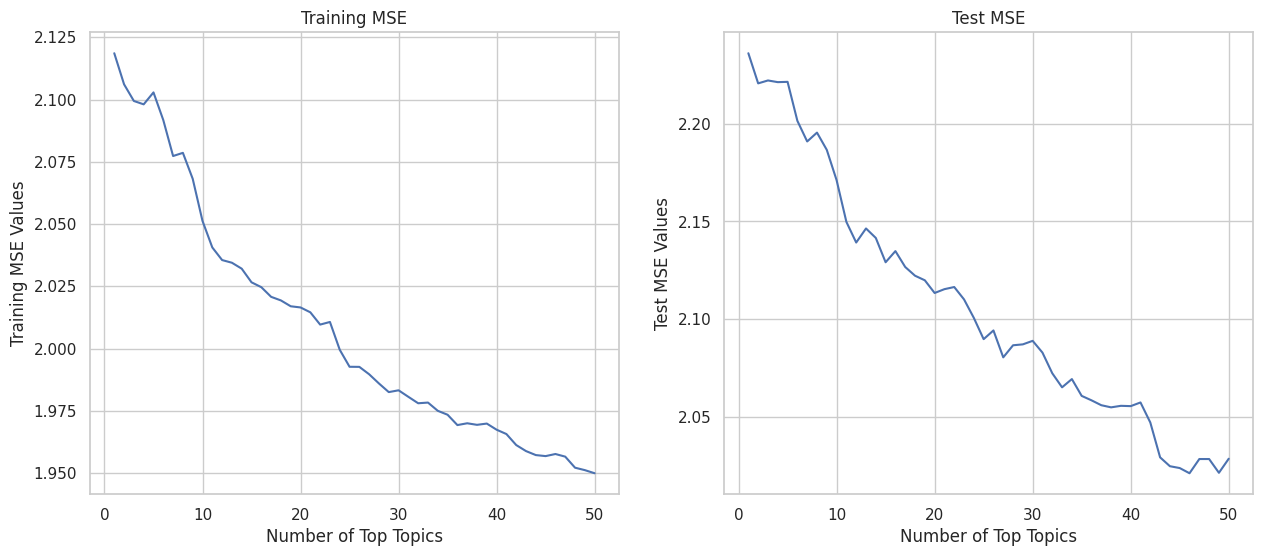

In [ ]:
# plot MSE vs. number of top topics
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title("Training MSE")
plt.plot(num_topics, training_mses)
plt.xlabel("Number of Top Topics")
plt.ylabel("Training MSE Values")

plt.subplot(122)
plt.title("Test MSE")
plt.plot(num_topics, test_mses)
plt.xlabel("Number of Top Topics")
plt.ylabel("Test MSE Values");

Both training and test MSE shows a decreasing trend as the number of top topics are included increases. To find the optimal number of top topics to be included in the regression model and avoid overfitting the model, we will find the lowest number of top topics to include with the smallest difference between training and test MSE.

In [ ]:
X_score = cleaned_embeddings
Y_score = merged_df['average_score'].values

X_score.shape, Y_score.shape

((21306, 256), (21306,))

In [ ]:
# Find number of topics with the smallest difference between training and test MSEs
min_diff_topics = min(range(len(training_mses)), key=lambda i: abs(training_mses[i] - test_mses[i]))

min_diff_topics

45

In [ ]:
# concatenate encoded topics as additional feature
top_n = min_diff_topics

X_score = np.concatenate((X_score, encoded_top_topic(df=merged_df, top_n=top_n).values), axis=1)

X_score.shape

(21306, 391)

In [ ]:
# split embeddings & features into training and test sets
X_train_score, X_test_score, Y_train_score, Y_test_score = train_test_split(X_score, Y_score, test_size=0.2, random_state=42)

# Train linear regression model for hardness score prediction
score_model = LinearRegression().fit(X_train_score,  Y_train_score)

# predictions on both train and test sets
Y_train_score_predict = np.round(score_model.predict(X_train_score)).astype(int)
Y_test_score_predict = np.round(score_model.predict(X_test_score)).astype(int)

# calculates the MSE of training set and test set
score_train_error = mean_squared_error(Y_train_score, Y_train_score_predict)
score_test_error = mean_squared_error(Y_test_score, Y_test_score_predict)

print(f"Training MSE (with top{top_n} topics OHE):", score_train_error)
print(f"Test MSE (with top{top_n} topics OHE):", score_test_error)

Training MSE (with top45 topics OHE): 1.9568437247385853
Test MSE (with top45 topics OHE): 2.0238607330934877


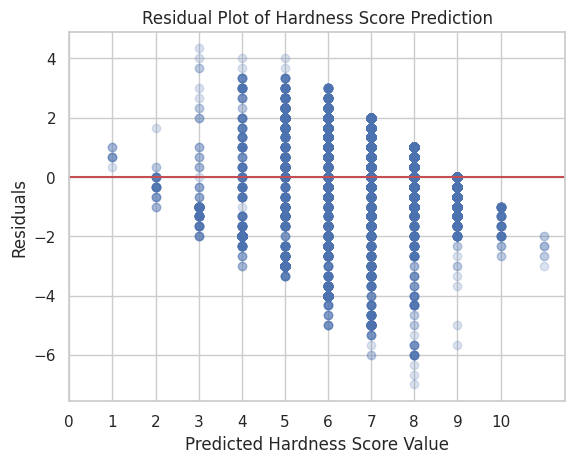

In [ ]:
# Residuals plot visualization
residuals = Y_train_score - Y_train_score_predict
plt.scatter(Y_train_score_predict, residuals, alpha=0.2)
plt.axhline(y=0, color='r')
plt.xlabel('Predicted Hardness Score Value')
plt.ylabel('Residuals')
plt.title('Residual Plot of Hardness Score Prediction')
plt.xticks(np.arange(0, 11, step=1))
plt.show();

### KMeans average score clustering

Incorportate cluster analysis on the embeddings before prediction to help identify groupings in the data that could reflect variations in hardness score

In [ ]:
# To find the optimal number of clusters with low MSE
training_mses_kmeans = []
test_mses_kmeans = []
num_clusters = []

for i in range(5):
  # initialize/reset X (features) and Y
  X_score = cleaned_embeddings
  Y_score = merged_df['average_score'].values

  # apply KMeans clustering to embedding features
  n_clusters = 50 + i
  kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)

  # fit and predict KMeans clustering
  clusters = kmeans.fit_predict(X_score)

  # concatenate KMeans clusters as additional features
  X_score = np.concatenate((X_score, clusters.reshape(-1, 1)), axis=1)

  # Code for average clustering
  cluster_df = pd.DataFrame(X_score)
  cluster_df['hardness_score'] = Y_score
  cluster_df['cluster'] = clusters

  cluster_averages = cluster_df.groupby('cluster')['hardness_score'].mean().to_dict()
  cluster_df['cluster_avg'] = cluster_df['cluster'].map(cluster_averages)

  # concatenate average clusterings as additional features
  X_score = np.concatenate((X_score, cluster_df['cluster_avg'].values.reshape(-1, 1)), axis=1)

  # split embeddings & features into training and test sets
  X_train_score, X_test_score, Y_train_score, Y_test_score = train_test_split(X_score, Y_score, test_size=0.2, random_state=42)

  # Train linear regression model for hardness score prediction
  score_model = LinearRegression().fit(X_train_score,  Y_train_score)

  # predictions on both train and test sets
  Y_train_score_predict = np.round(score_model.predict(X_train_score)).astype(int)
  Y_test_score_predict = np.round(score_model.predict(X_test_score)).astype(int)

  # calculates the MSE of training set and test set
  score_train_error = mean_squared_error(Y_train_score, Y_train_score_predict)
  score_test_error = mean_squared_error(Y_test_score, Y_test_score_predict)

  # append calculated MSEs and number of topics
  training_mses_kmeans.append(score_train_error)
  test_mses_kmeans.append(score_test_error)
  num_clusters.append(n_clusters)

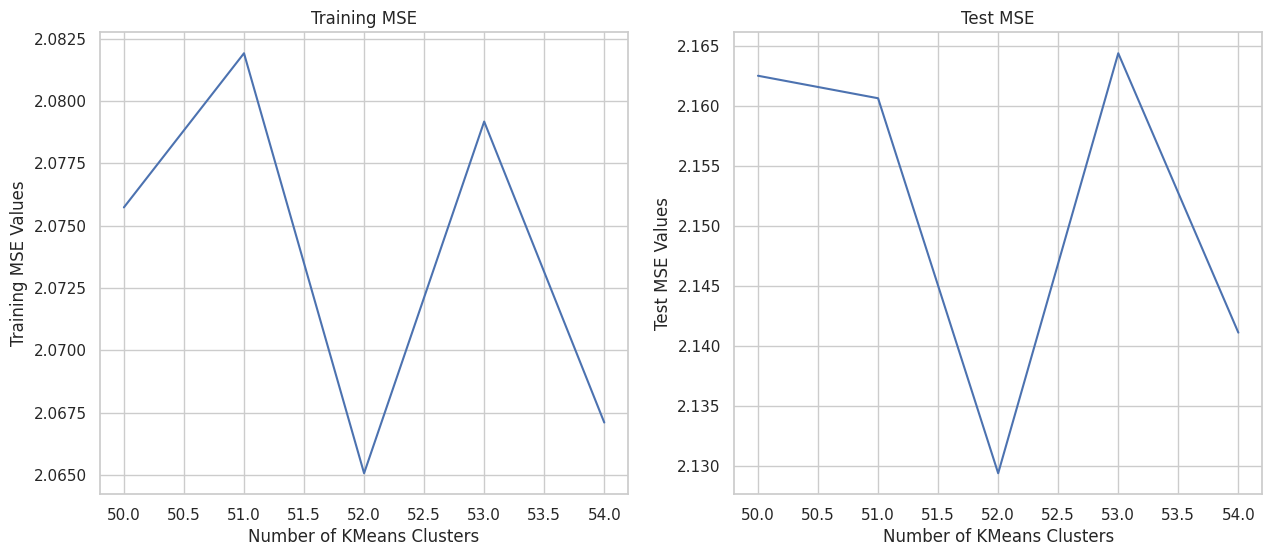

In [ ]:
# plot MSE vs. kmeans clusters
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title("Training MSE")
plt.plot(num_clusters, training_mses_kmeans)
plt.xlabel("Number of KMeans Clusters")
plt.ylabel("Training MSE Values")

plt.subplot(122)
plt.title("Test MSE")
plt.plot(num_clusters, test_mses_kmeans)
plt.xlabel("Number of KMeans Clusters")
plt.ylabel("Test MSE Values");

In [ ]:
X_score = cleaned_embeddings
Y_score = merged_df['average_score'].values

X_score.shape, Y_score.shape

((21306, 256), (21306,))

In [ ]:
# Find number of clusters with the smallest difference between training and test MSEs
min_diff_clusters = min(range(len(training_mses_kmeans)), key=lambda i: abs(training_mses_kmeans[i] - test_mses_kmeans[i])) + 50

min_diff_clusters

52

In [ ]:
# apply KMeans clustering to embedding features
n_clusters = min_diff_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)

# fit and predict KMeans clustering
clusters = kmeans.fit_predict(X_score)

# concatenate KMeans clusters as additional features
X_score = np.concatenate((X_score, clusters.reshape(-1, 1)), axis=1)

# Code for average clustering
cluster_df = pd.DataFrame(X_score)
cluster_df['hardness_score'] = Y_score
cluster_df['cluster'] = clusters

cluster_averages = cluster_df.groupby('cluster')['hardness_score'].mean().to_dict()
cluster_df['cluster_avg'] = cluster_df['cluster'].map(cluster_averages)

# concatenate average clusterings as additional features
X_score = np.concatenate((X_score, cluster_df['cluster_avg'].values.reshape(-1, 1)), axis=1)

X_score.shape

(21306, 258)

In [ ]:
# split embeddings & features into training and test sets
X_train_score, X_test_score, Y_train_score, Y_test_score = train_test_split(X_score, Y_score, test_size=0.2, random_state=42)

# Train linear regression model for hardness score prediction
score_model = LinearRegression().fit(X_train_score,  Y_train_score)

# predictions on both train and test sets
Y_train_score_predict = np.round(score_model.predict(X_train_score)).astype(int)
Y_test_score_predict = np.round(score_model.predict(X_test_score)).astype(int)

# calculates the MSE of training set and test set
score_train_error = mean_squared_error(Y_train_score, Y_train_score_predict)
score_test_error = mean_squared_error(Y_test_score, Y_test_score_predict)

print(f"Training MSE (with average score clustering n={n_clusters}):", score_train_error)
print(f"Test MSE (with average score clustering n={n_clusters}):", score_test_error)

Training MSE (with average score clustering n=52): 2.0650734047823933
Test MSE (with average score clustering n=52): 2.129366755305282


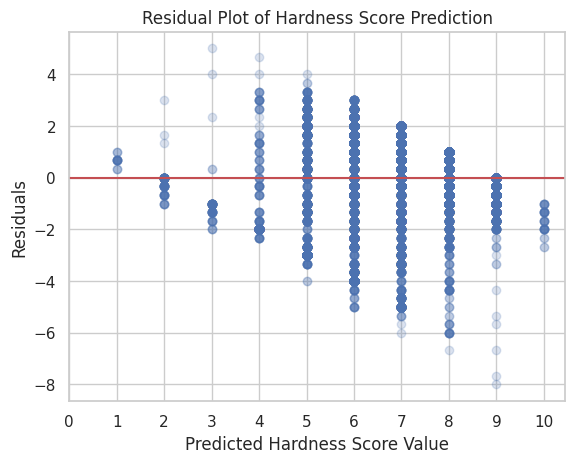

In [ ]:
# Residuals plot visualization
residuals = Y_train_score - Y_train_score_predict
plt.scatter(Y_train_score_predict, residuals, alpha=0.2)
plt.axhline(y=0, color='r')
plt.xlabel('Predicted Hardness Score Value')
plt.ylabel('Residuals')
plt.title('Residual Plot of Hardness Score Prediction')
plt.xticks(np.arange(0, 11, step=1))
plt.show();

### Average score clustering + topics OHE

Combine both average score cluterings and top topics OHE feature engineering for modeling

In [ ]:
X_score = cleaned_embeddings
Y_score = merged_df['average_score'].values

X_score.shape, Y_score.shape

((21306, 256), (21306,))

In [ ]:
# apply KMeans clustering to embedding features

n_clusters = min_diff_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)

# fit and predict KMeans clustering
clusters = kmeans.fit_predict(X_score)

# Code for average clustering
cluster_df = pd.DataFrame(X_score)
cluster_df['hardness_score'] = Y_score
cluster_df['cluster'] = clusters

cluster_averages = cluster_df.groupby('cluster')['hardness_score'].mean().to_dict()
cluster_df['cluster_avg'] = cluster_df['cluster'].map(cluster_averages)

# concatenate average clusterings as additional features
X_score = np.concatenate((X_score, cluster_df['cluster_avg'].values.reshape(-1, 1)), axis=1)

X_score.shape

(21306, 257)

In [ ]:
# concatenate encoded topics as additional feature
X_score = np.concatenate((X_score, encoded_top_topic(df=merged_df, top_n=min_diff_topics).values), axis=1)

X_score.shape

(21306, 392)

In [ ]:
# split embeddings & features into training and test sets
X_train_score, X_test_score, Y_train_score, Y_test_score = train_test_split(X_score, Y_score, test_size=0.2, random_state=42)

# Train linear regression model for hardness score prediction
score_model = LinearRegression().fit(X_train_score,  Y_train_score)

# predictions on both train and test sets
Y_train_score_predict = np.round(score_model.predict(X_train_score)).astype(int)
Y_test_score_predict = np.round(score_model.predict(X_test_score)).astype(int)

# calculates the MSE of training set and test set
score_train_error = mean_squared_error(Y_train_score, Y_train_score_predict)
score_test_error = mean_squared_error(Y_test_score, Y_test_score_predict)

print("Training MSE (average score cluster + topics OHE):", score_train_error)
print("Test MSE (average score cluster + topics OHE):", score_test_error)

Training MSE (average score cluster + topics OHE): 1.9201543716915694
Test MSE (average score cluster + topics OHE): 1.9432256634861045


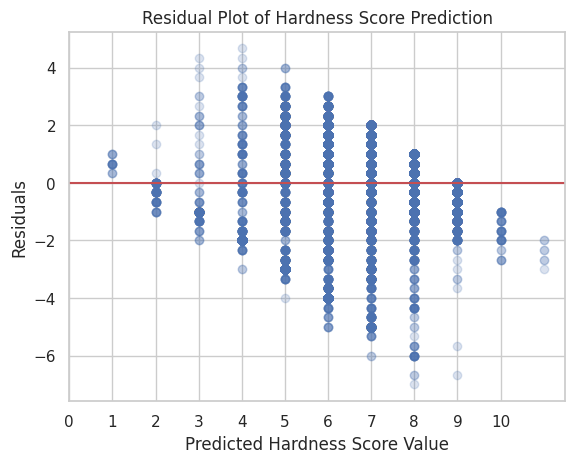

In [ ]:
# Residuals plot visualization
residuals = Y_train_score - Y_train_score_predict
plt.scatter(Y_train_score_predict, residuals, alpha=0.2)
plt.axhline(y=0, color='r')
plt.xlabel('Predicted Hardness Score Value')
plt.ylabel('Residuals')
plt.title('Residual Plot of Hardness Score Prediction')
plt.xticks(np.arange(0, 11, step=1))
plt.show();

### Feature Engineering Function for Hardness Score


In [ ]:
# put all feature engineering into a function for hardness score prediction

def score_feat_engineer(embedding, df, n_clusters, top_n, random_state=42):
  '''
  This function performs feature engineering for hardness score prediction and concatenate the features together.

  Parameters
  ----------
  embedding : np.array
    Embedding data to be used as features for modeling.
  df : DataFrame
      The DataFrame containing the topic columns to be one-hot encoded.
  n_clusters : int
      The number for clusters for KMeans clustering.
  top_n : int
      The number of top topics to encode.
  random_state : int
      Controls the the shuffling for feature engineerings.
      The default random_state is 42 for reproducibilit.

  Returns
  -------
  X_engineered: np.array
      A NumPy array with embedding data and engineered features concatenated for hardness score prediction.
  '''

  # apply KMeans clustering to embedding features, then fit and predict KMeans clustering
  kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
  clusters = kmeans.fit_predict(embedding)

  # Code for average clustering
  cluster_df = pd.DataFrame(embedding)
  cluster_df['cluster'] = clusters

  # create a DataFrame for validation data with predicted clusters
  cluster_df = pd.DataFrame(embedding)
  cluster_df['cluster'] = clusters

  # look up average hardness score of each predicted cluster from the training set
  cluster_df['cluster_avg'] = cluster_df['cluster'].map(cluster_averages)

  # concatenate cluster average to validation data
  embedding = np.concatenate((embedding, cluster_df['cluster_avg'].values.reshape(-1, 1)), axis=1)

  # standardize topic modeling columns in validation data
  df = standardize_topics_in_df(df)

  # Concatenate cluster average and encoded topics in validation data
  X_engineered = np.concatenate((embedding, encoded_top_topic(df=df, top_n=top_n).values), axis=1)

  return X_engineered

The following is to ensure the `score_feat_engineer` function is working properly and is correctly implemented.

In [ ]:
X_score = cleaned_embeddings
Y_score = merged_df['average_score'].values

X_score.shape, Y_score.shape

((21306, 256), (21306,))

In [ ]:
# To ensure the feature enginnering function is working properly
X_score = score_feat_engineer(X_score, merged_df, n_clusters=min_diff_clusters, top_n=min_diff_topics)

X_score.shape

(21306, 392)

In [ ]:
# split embeddings & features into training and test sets
X_train_score, X_test_score, Y_train_score, Y_test_score = train_test_split(X_score, Y_score, test_size=0.2, random_state=42)

# Train linear regression model for hardness score prediction
score_model = LinearRegression().fit(X_train_score,  Y_train_score)

# predictions on both train and test sets
Y_train_score_predict = np.round(score_model.predict(X_train_score)).astype(int)
Y_test_score_predict = np.round(score_model.predict(X_test_score)).astype(int)

# calculates the MSE of training set and test set
score_train_error = mean_squared_error(Y_train_score, Y_train_score_predict)
score_test_error = mean_squared_error(Y_test_score, Y_test_score_predict)

print("Training MSE (using score_feat_engineer function):", score_train_error)
print("Test MSE (using score_feat_engineer function):", score_test_error)

Training MSE (using score_feat_engineer function): 1.9201543716915694
Test MSE (using score_feat_engineer function): 1.9432256634861045


### KFold Cross-Validation (Hardness Prediction)

In [ ]:
X_score.shape, Y_score.shape

((21306, 392), (21306,))

In [ ]:
# define number of KFolds for cross validation
n_splits = 5

# initalize a KFold object for cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# initialize lists to store calculated MSE for each fold
train_mse_scores = []
test_mse_scores = []

for i, (train_idx, test_idx) in enumerate(kf.split(X_score), 1):
  # split data into training and test sets
  X_score_train, X_score_test = X_score[train_idx], X_score[test_idx]
  Y_score_train, Y_score_test = Y_score[train_idx], Y_score[test_idx]

  # train the model
  kf_score_model = LinearRegression()
  kf_score_model.fit(X_score_train, Y_score_train)

  # predict training and test data
  Y_train_pred_kf = kf_score_model.predict(X_score_train)
  Y_test_pred_kf = kf_score_model.predict(X_score_test)

  # calculate MSE for the fold
  train_mse_score = mean_squared_error(Y_score_train, Y_train_pred_kf)
  test_mse_score = mean_squared_error(Y_score_test, Y_test_pred_kf)

  # append calculated MSE scores to the lists
  train_mse_scores.append(train_mse_score)
  test_mse_scores.append(test_mse_score)

  # print each fold MSE score
  print(f"Fold {i}: Train MSE = {train_mse_score}, Test MSE = {test_mse_score}")

# calculate and print the average MSE scores across all the folds
avg_train_mse = np.mean(train_mse_scores)
print("Average Train MSE: ", avg_train_mse)

avg_test_mse = np.mean(test_mse_scores)
print("Average Test MSE: ", avg_test_mse)

Fold 1: Train MSE = 1.83183271478996, Test MSE = 1.8926737381227339
Fold 2: Train MSE = 1.8309431814744617, Test MSE = 1.9021868192136666
Fold 3: Train MSE = 1.8241739845776768, Test MSE = 1.922230639284594
Fold 4: Train MSE = 1.8109141291851838, Test MSE = 1.9793591997724829
Fold 5: Train MSE = 1.8408628824425382, Test MSE = 1.861092544804351
Average Train MSE:  1.8277453784939641
Average Test MSE:  1.9115085882395657


# Validation Data

In [ ]:
validation_data_1 = pd.read_json(
    'data/arena-validation-set-prompt-only.jsonl.gz',
    lines=True,
)
validation_data_1.shape

In [ ]:
validation_data_2 = pd.read_json(
    'data/arena-validation-set-topic-modeling.jsonl.gz',
    lines=True,
)
validation_data_2.shape

(3206, 5)

In [ ]:
validation_embedding = np.load(
    'data/arena-validation-set-prompts-embeddings.npy'
)
validation_embedding.shape

(3206, 256)

In [ ]:
validation_data = validation_data_1.join(validation_data_2, lsuffix='_1', rsuffix='_2')

validation_data.drop(['prompt_2', 'question_id_2'], axis=1, inplace=True)
validation_data.rename(columns={'prompt_1': 'prompt', 'question_id_1': 'question_id'}, inplace=True)

In [ ]:
def test_set_feature(validation_dataframe):

    #add ELO ranking column
    # Check if 'rank_model_a' already exists; if not, perform the merge
    if 'rank_model_a' not in validation_dataframe.columns:
        validation_dataframe = validation_dataframe.merge(elo_df, left_on='model_a', right_on='Model', how='left')
        validation_dataframe.rename(columns={'ELO rating': 'rank_model_a'}, inplace=True)
        validation_dataframe.drop(columns='Model', inplace=True)  # Drop the extra 'Model' column after merge

    if 'rank_model_b' not in validation_dataframe.columns:
        validation_dataframe = validation_dataframe.merge(elo_df, left_on='model_b', right_on='Model', how='left')
        validation_dataframe.rename(columns={'ELO rating': 'rank_model_b'}, inplace=True)
        validation_dataframe.drop(columns='Model', inplace=True)

    #add model-a win rate column
    validation_dataframe['model-a win fraction'] = validation_dataframe.apply(lambda row: win_fraction.at[row['model_a'], row['model_b']], axis=1)

    #add prompt_length column
    validation_dataframe["prompt_length"] = validation_dataframe["prompt"].str.len()

    #add ranking ratio
    validation_dataframe['ranking_ratio'] = validation_dataframe['rank_model_a']/validation_dataframe['rank_model_b']

    #clustering and OHE
    validation_dataframe = apply_kmeans_to_embeddings_and_onehot(validation_dataframe, validation_embedding, n_clusters=51)
    return validation_dataframe

validation_df = test_set_feature(validation_data)
#validation_df.head()

In [ ]:
Features_cols = ["prompt_length",'ranking_ratio', 'model-a win fraction']
def extract_feature(validation_data, Features_cols):
    return validation_data[Features_cols]

In [ ]:
Features_cols.extend(cluster_columns)
X_validation = extract_feature(validation_df, Features_cols)
y_validation_pred = model.predict(X_validation)
y_validation_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([1, 1, 1, ..., 0, 0, 1])

In [ ]:
result = validation_df[['question_id']]
result = result.copy()
result['winner'] = y_validation_pred
#result.head()
winner_mapping = {
    0: 'model_a',
    1: 'model_b',
    2: 'tie',
    3: 'tie (bothbad)'
}

result['winner'] = result['winner'].map(winner_mapping)

In [ ]:
X_val_score = validation_embedding

X_val_score.shape

(3206, 256)

In [ ]:
# predict clusters for validation data using the trained KMeans model
val_clusters = kmeans.predict(X_val_score)

# create a DataFrame for validation data with predicted clusters
val_cluster_df = pd.DataFrame(X_val_score)
val_cluster_df['cluster'] = val_clusters

# look up average hardness score of each predicted cluster from the training set
val_cluster_df['cluster_avg'] = val_cluster_df['cluster'].map(cluster_averages)

# concatenate the cluster averages to the validation data as additional features
X_val_score = np.concatenate((X_val_score, val_cluster_df['cluster_avg'].values.reshape(-1, 1)), axis=1)

X_val_score.shape

(3206, 257)

In [ ]:
# standardize topic modeling columns in validation data
validation_data = standardize_topics_in_df(validation_data)

# Concatenate encoded topics in validation data
X_val_score = np.concatenate((X_val_score, encoded_top_topic(df=validation_data, top_n=top_n).values), axis=1)

X_val_score.shape

(3206, 392)

In [ ]:
# prediction on validation data for hardness score
Y_val_score_predict = np.round(score_model.predict(X_val_score)).astype(int)

X_val_score.shape, Y_val_score_predict.shape

((3206, 392), (3206,))

In [ ]:
result = result.copy()
result['hardness_score'] = Y_val_score_predict
result.to_csv('NLP_Predictions.csv', index=False)

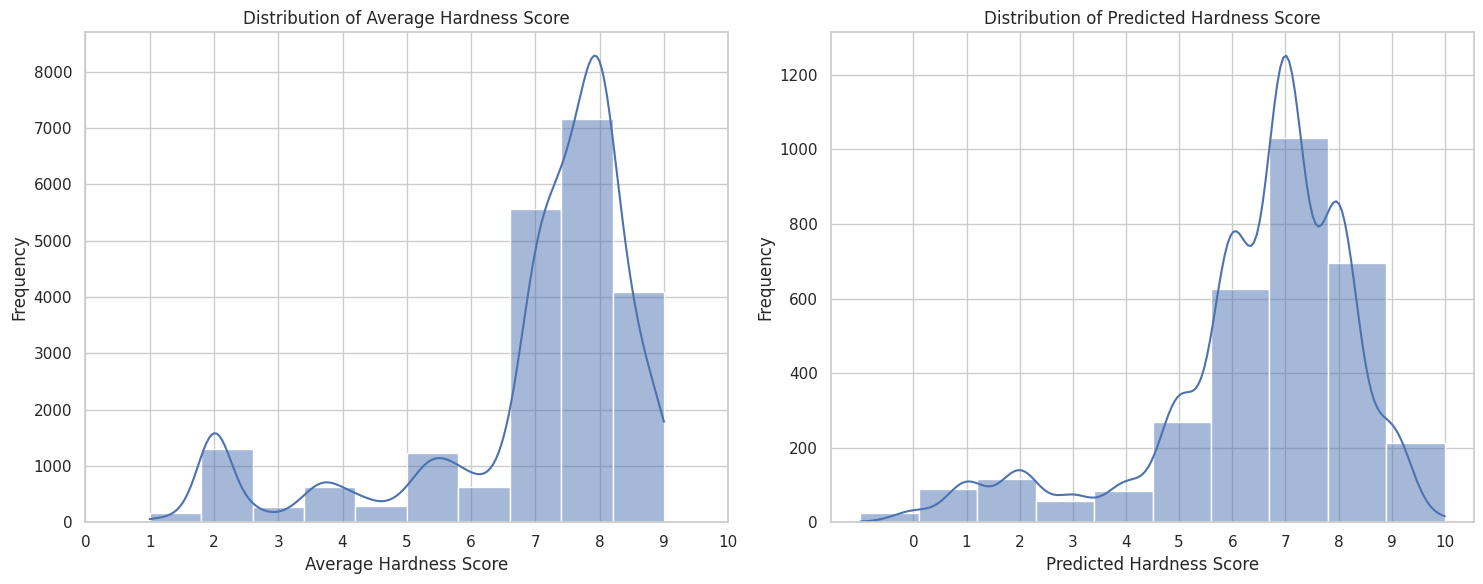

In [ ]:
# Plot average hardness score distribution in original data and hardness score distribution predicted by the model
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.histplot(data=merged_df['average_score'], bins=10, kde=True)
plt.title('Distribution of Average Hardness Score')
plt.xlabel('Average Hardness Score')
plt.ylabel('Frequency')
plt.xticks(range(0, 11))

plt.subplot(122)
sns.histplot(data=Y_val_score_predict, bins=10, kde=True)
plt.title('Distribution of Predicted Hardness Score')
plt.xlabel('Predicted Hardness Score')
plt.ylabel('Frequency')
plt.xticks(range(0, 11))

plt.tight_layout()
plt.show()